# Benchmark aggregation by hardware

This notebook loads a benchmark CSV (same format as the project outputs) and builds
per-hardware dataframes that include IDLE rows and the mean across repeats for each run.


In [68]:
from pathlib import Path
import pandas as pd

# Update this path if needed
csv_path = Path("4070_cpu_benchmark_results.csv")
if not csv_path.exists():
    csv_path = Path("..") / csv_path

csv_path

PosixPath('../4070_cpu_benchmark_results.csv')

In [69]:
df = pd.read_csv(csv_path)
df.head()

,Timestamp,Phase,Hardware,Model_Name,Size_MB,ImgSz,E2E_Time_ms,Device_Time_ms,mAP50,Precision,...,MATCH_IOU,MAX_DET,WARMUP,ultralytics,depthai,opencv,torch,cuda,tensorrt,onnxruntime
0,"2026-01-15T14:08:28,739",idle,GPU_ORT_CUDA_ALL,IDLE,0.00,0,0.00,0.00,0.00,0.0000,...,0.5,300,10,8.3.241,2.28.0.0,4.11.0,2.9.1+cu128,12.8,NaN,1.23.2
1,"2026-01-15T14:08:31,374",run,GPU_ORT_CUDA_ALL,yolo11m_640_fp32,76.89,640,12.93,10.01,0.78,0.7906,...,0.5,300,10,8.3.241,2.28.0.0,4.11.0,2.9.1+cu128,12.8,NaN,1.23.2
2,"2026-01-15T14:08:33,976",run,GPU_ORT_CUDA_ALL,yolo11m_640_fp32,76.89,640,12.59,9.90,0.78,0.7906,...,0.5,300,10,8.3.241,2.28.0.0,4.11.0,2.9.1+cu128,12.8,NaN,1.23.2
3,"2026-01-15T14:08:36,595",run,GPU_ORT_CUDA_ALL,yolo11m_640_fp32,76.89,640,12.61,9.91,0.78,0.7906,...,0.5,300,10,8.3.241,2.28.0.0,4.11.0,2.9.1+cu128,12.8,NaN,1.23.2
4,"2026-01-15T14:08:39,200",run,GPU_ORT_CUDA_BASIC,yolo11m_640_fp32,76.89,640,14.66,11.74,0.78,0.7906,...,0.5,300,10,8.3.241,2.28.0.0,4.11.0,2.9.1+cu128,12.8,NaN,1.23.2


In [70]:
def aggregate_by_hardware(df_in: pd.DataFrame, hardware_prefix: str) -> pd.DataFrame:
    hw_df = df_in[df_in["Hardware"].str.startswith(hardware_prefix, na=False)].copy()
    if hw_df.empty:
        return pd.DataFrame()

    # Convert numeric columns
    for col in hw_df.columns:
        if col in {"Timestamp", "Phase", "Hardware", "Model_Name", "Dataset", "Backend",
                   "ORT_Level_Requested", "Providers_Used"}:
            continue
        hw_df[col] = pd.to_numeric(hw_df[col], errors="coerce")

    id_cols = [c for c in hw_df.columns if c != "Timestamp" and not pd.api.types.is_numeric_dtype(hw_df[c])]
    num_cols = [c for c in hw_df.columns if c not in id_cols + ["Timestamp"]]

    agg = (
        hw_df
        .groupby(id_cols, dropna=False)[num_cols]
        .mean(numeric_only=True)
        .reset_index()
    )

    # Keep idle first, then run rows ordered by model name
    if "Phase" in agg.columns and "Model_Name" in agg.columns:
        agg = agg.sort_values(["Phase", "Model_Name"], ascending=[True, True])

    return agg


df_gpu = aggregate_by_hardware(df, "GPU_")
df_cpu = aggregate_by_hardware(df, "CPU_")

df_gpu, df_cpu

(   Phase              Hardware        Model_Name ORT_Level_Requested  \
 0   idle      GPU_ORT_CUDA_ALL              IDLE            all->all   
 1    run      GPU_ORT_CUDA_ALL  yolo11m_256_fp16            all->all   
 31   run    GPU_ORT_CUDA_BASIC  yolo11m_256_fp16        basic->basic   
 61   run  GPU_ORT_CUDA_DISABLE  yolo11m_256_fp16    disable->disable   
 2    run      GPU_ORT_CUDA_ALL  yolo11m_256_fp32            all->all   
 ..   ...                   ...               ...                 ...   
 59   run    GPU_ORT_CUDA_BASIC  yolo11s_640_fp16        basic->basic   
 89   run  GPU_ORT_CUDA_DISABLE  yolo11s_640_fp16    disable->disable   
 30   run      GPU_ORT_CUDA_ALL  yolo11s_640_fp32            all->all   
 60   run    GPU_ORT_CUDA_BASIC  yolo11s_640_fp32        basic->basic   
 90   run  GPU_ORT_CUDA_DISABLE  yolo11s_640_fp32    disable->disable   
 
                                 Providers_Used  Dataset      Backend  Size_MB  \
 0   CUDAExecutionProvider,CPUExecutionP

In [71]:
# Quick sanity checks
print("GPU rows:", len(df_gpu))
print("CPU rows:", len(df_cpu))

print("GPU idle rows:", (df_gpu["Phase"] == "idle").sum() if not df_gpu.empty else 0)
print("CPU idle rows:", (df_cpu["Phase"] == "idle").sum() if not df_cpu.empty else 0)

GPU rows: 91
CPU rows: 91
GPU idle rows: 1
CPU idle rows: 1


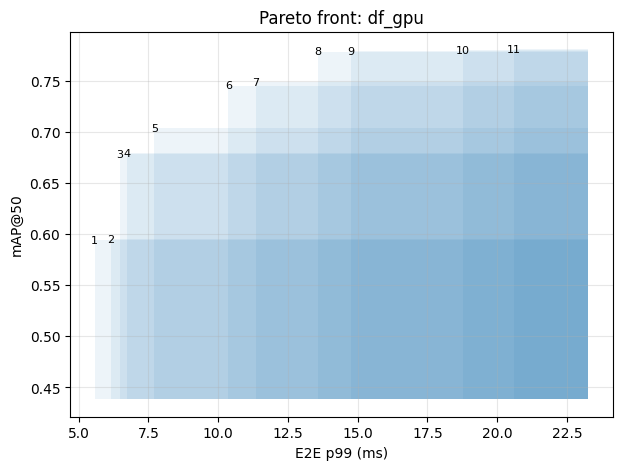

,Pareto_id,Label
0,1,s 256 fp32 ORT ALL
1,2,s 256 fp16 ORT ALL
2,3,m 256 fp32 ORT BASIC
3,4,m 256 fp16 ORT BASIC
4,5,m 320 fp32 ORT ALL
5,6,m 416 fp32 ORT ALL
6,7,m 416 fp16 ORT ALL
7,8,m 512 fp32 ORT ALL
8,9,m 512 fp16 ORT ALL
9,10,m 640 fp32 ORT ALL


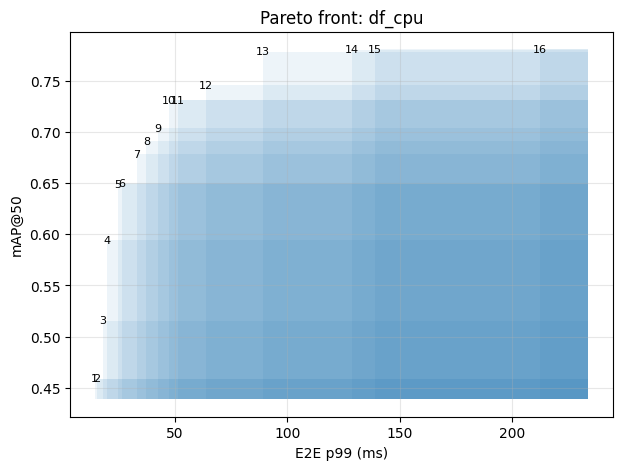

,Pareto_id,Label
0,1,n 256 fp32 ORT ALL
1,2,n 256 fp16 ORT ALL
2,3,n 320 fp16 ORT ALL
3,4,s 256 fp16 ORT ALL
4,5,s 320 fp32 ORT ALL
5,6,s 320 fp16 ORT ALL
6,7,m 256 fp32 ORT ALL
7,8,s 416 fp32 ORT ALL
8,9,m 320 fp32 ORT ALL
9,10,s 512 fp32 ORT ALL


In [72]:
import re
import numpy as np
import matplotlib.pyplot as plt

def pareto_min_max(df: pd.DataFrame, min_col: str, max_col: str) -> pd.DataFrame:
    work = df.copy()
    work = work[(work["Phase"] == "run") & work[min_col].notna() & work[max_col].notna()]
    if work.empty:
        return work

    vals = work[[min_col, max_col]].values
    is_pareto = np.ones(len(work), dtype=bool)

    for i, (x, y) in enumerate(vals):
        if not is_pareto[i]:
            continue
        dominated = (vals[:, 0] <= x) & (vals[:, 1] >= y) & (
            (vals[:, 0] < x) | (vals[:, 1] > y)
        )
        if dominated.any():
            is_pareto[i] = False

    return work[is_pareto].sort_values([min_col, max_col], ascending=[True, False])


def short_label(row: pd.Series) -> str:
    name = str(row.get("Model_Name", ""))
    match = re.search(r"yolo11([nsm])_(\d+)_(fp16|fp32|int8)", name)
    if match:
        scale, imgsz, quant = match.groups()
        base = f"{scale} {imgsz} {quant}"
    else:
        base = name

    hardware = str(row.get("Hardware", ""))
    backend = ""
    opt = ""

    if "ORT" in hardware:
        backend = "ORT"
        m2 = re.search(r"_(ALL|BASIC|DISABLE)\b", hardware)
        if m2:
            opt = m2.group(1)
        else:
            ort = str(row.get("ORT_Level_Requested", ""))
            if ort and ort != "N/A":
                opt = ort.split("->")[-1]
    elif "TRT" in hardware:
        backend = "TRT"
        m2 = re.search(r"_H(\d+)_SP(\d+)", hardware)
        if m2:
            opt = f"H{m2.group(1)}SP{m2.group(2)}"
    elif hardware.startswith("OAK"):
        backend = "OAK"
        m2 = re.search(r"_SHAVES_(\d+)", hardware)
        if m2:
            opt = f"S{m2.group(1)}"
    else:
        backend = str(row.get("Backend", "" )).upper()

    if backend:
        return f"{base} {backend} {opt}".strip()
    return base


all_dfs = {
    name: val
    for name, val in globals().items()
    if name.startswith("df_")
    and isinstance(val, pd.DataFrame)
    and not val.empty
    and {"Phase", "Latency_p99", "mAP50"}.issubset(val.columns)
}

pareto_dfs = {
    name: pareto_min_max(val, "Latency_p99", "mAP50")
    for name, val in all_dfs.items()
}

for name, pdf in pareto_dfs.items():
    if pdf.empty:
        print(f"{name}: no rows")
        continue

    pdf = pdf.reset_index(drop=True)
    pdf["Pareto_id"] = np.arange(1, len(pdf) + 1)
    pdf["Label"] = pdf.apply(short_label, axis=1)

    # Reference point for hypervolume shading (worse corner)
    work = all_dfs[name]
    work = work[(work["Phase"] == "run") & work["Latency_p99"].notna() & work["mAP50"].notna()]
    ref_x = work["Latency_p99"].max() * 1.05
    ref_y = max(0.0, work["mAP50"].min() - 0.02)

    fig, ax = plt.subplots(figsize=(7, 5))

    # Hypervolume (dominated region) shading
    for _, row in pdf.iterrows():
        ax.fill_between(
            [row["Latency_p99"], ref_x],
            ref_y,
            row["mAP50"],
            color="tab:blue",
            alpha=0.08,
            linewidth=0,
        )

    # Points + numeric labels
    for _, row in pdf.iterrows():
        ax.text(
            row["Latency_p99"],
            row["mAP50"],
            str(int(row["Pareto_id"])),
            fontsize=8,
            ha="center",
            va="center",
        )
    ax.set_xlabel("E2E p99 (ms)")
    ax.set_ylabel("mAP@50")
    ax.set_title(f"Pareto front: {name}")
    ax.grid(True, alpha=0.3)
    plt.show()

    # Mapping table
    display(pdf[["Pareto_id", "Label"]])


In [73]:
# Top-3 tables per objective
import numpy as np

def build_top_tables(df_in: pd.DataFrame, name: str) -> None:
    if df_in.empty:
        print(f"{name}: empty dataframe")
        return

    work = df_in.copy()
    for col in work.columns:
        if col in {"Timestamp", "Phase", "Hardware", "Model_Name", "Dataset", "Backend",
                   "ORT_Level_Requested", "Providers_Used"}:
            continue
        work[col] = pd.to_numeric(work[col], errors="coerce")

    power_col = "Power_W_P95" if "Power_W_P95" in work.columns else None

    delta_cols = []
    if power_col:
        delta_cols.append(power_col)
    for c in ["RAM_RSS_MB_Mean", "RAM_Sys_Used_MB_Mean", "VRAM_Used_MB_Mean"]:
        if c in work.columns:
            delta_cols.append(c)

    if delta_cols and "Phase" in work.columns and "Hardware" in work.columns:
        idle = work[work["Phase"] == "idle"]
        if not idle.empty:
            base_by_hw = (
                idle.groupby("Hardware")[delta_cols]
                .mean(numeric_only=True)
                .add_prefix("idle_")
            )
            base_all = idle[delta_cols].mean(numeric_only=True)
            work = work.merge(base_by_hw, left_on="Hardware", right_index=True, how="left")
            for c in delta_cols:
                idle_col = f"idle_{c}"
                if idle_col not in work.columns:
                    work[idle_col] = np.nan
                if c in base_all.index:
                    work[idle_col] = work[idle_col].fillna(base_all[c])
                work[f"{c}_delta"] = work[c] - work[idle_col]

    use_cols = ["Hardware", "Model_Name", "Latency_p99", "mAP50", "Size_MB"]
    if "Pareto_id" in work.columns:
        use_cols.append("Pareto_id")
    if power_col:
        use_cols.append(f"{power_col}_delta")
    if "RAM_RSS_MB_Mean_delta" in work.columns:
        use_cols.append("RAM_RSS_MB_Mean_delta")
    if "RAM_Sys_Used_MB_Mean_delta" in work.columns:
        use_cols.append("RAM_Sys_Used_MB_Mean_delta")
    if "VRAM_Used_MB_Mean_delta" in work.columns:
        use_cols.append("VRAM_Used_MB_Mean_delta")

    run = work[work["Phase"] == "run"].copy()
    if run.empty:
        print(f"{name}: no run rows")
        return

    obj1 = run.sort_values(["mAP50", "Latency_p99"], ascending=[False, True]).head(3)
    obj2 = run.sort_values(["Latency_p99", "mAP50"], ascending=[True, False]).head(3)

    print(f"{name} - objectif 1 (mAP50 desc, p99 asc)")
    display(obj1[use_cols])
    print(f"{name} - objectif 2 (p99 asc, mAP50 desc)")
    display(obj2[use_cols])


dfs_for_tables = {
    name: val
    for name, val in globals().items()
    if name.startswith("df_")
    and isinstance(val, pd.DataFrame)
    and not val.empty
    and {"Phase", "Latency_p99", "mAP50"}.issubset(val.columns)
}

for name, df in dfs_for_tables.items():
    build_top_tables(df, name)


df_gpu - objectif 1 (mAP50 desc, p99 asc)


,Hardware,Model_Name,Latency_p99,mAP50,Size_MB,Power_W_P95_delta,RAM_RSS_MB_Mean_delta,RAM_Sys_Used_MB_Mean_delta,VRAM_Used_MB_Mean_delta
9,GPU_ORT_CUDA_ALL,yolo11m_640_fp16,20.600000,0.7809,38.48,57.000000,1002.816667,965.130000,146.0
39,GPU_ORT_CUDA_BASIC,yolo11m_640_fp16,21.866667,0.7805,38.48,68.666667,1011.640000,1033.523333,146.0
69,GPU_ORT_CUDA_DISABLE,yolo11m_640_fp16,22.113333,0.7805,38.48,69.000000,1012.996667,998.983333,146.0


df_gpu - objectif 2 (p99 asc, mAP50 desc)


,Hardware,Model_Name,Latency_p99,mAP50,Size_MB,Power_W_P95_delta,RAM_RSS_MB_Mean_delta,RAM_Sys_Used_MB_Mean_delta,VRAM_Used_MB_Mean_delta
22,GPU_ORT_CUDA_ALL,yolo11s_256_fp32,5.576667,0.5942,36.12,53.666667,1056.04,1498.060000,21.333333
52,GPU_ORT_CUDA_BASIC,yolo11s_256_fp32,5.640000,0.5942,36.12,78.333333,1056.04,1474.056667,20.666667
82,GPU_ORT_CUDA_DISABLE,yolo11s_256_fp32,5.823333,0.5942,36.12,78.666667,1056.04,1460.900000,20.000000


df_cpu - objectif 1 (mAP50 desc, p99 asc)


,Hardware,Model_Name,Latency_p99,mAP50,Size_MB,Power_W_P95_delta,RAM_RSS_MB_Mean_delta,RAM_Sys_Used_MB_Mean_delta,VRAM_Used_MB_Mean_delta
39,CPU_ORT_PC_x86_64_SEQ_BASIC,yolo11m_640_fp16,212.330000,0.7806,38.48,65.333333,430.006667,-192.683333,NaN
69,CPU_ORT_PC_x86_64_SEQ_DISABLE,yolo11m_640_fp16,222.396667,0.7806,38.48,67.333333,430.120000,-36.223333,NaN
9,CPU_ORT_PC_x86_64_SEQ_ALL,yolo11m_640_fp16,139.090000,0.7805,38.48,66.000000,489.746667,-168.620000,NaN


df_cpu - objectif 2 (p99 asc, mAP50 desc)


,Hardware,Model_Name,Latency_p99,mAP50,Size_MB,Power_W_P95_delta,RAM_RSS_MB_Mean_delta,RAM_Sys_Used_MB_Mean_delta,VRAM_Used_MB_Mean_delta
12,CPU_ORT_PC_x86_64_SEQ_ALL,yolo11n_256_fp32,14.54,0.4589,10.07,63.333333,88.39,1498.090000,NaN
42,CPU_ORT_PC_x86_64_SEQ_BASIC,yolo11n_256_fp32,14.93,0.4589,10.07,63.333333,89.58,1547.093333,NaN
72,CPU_ORT_PC_x86_64_SEQ_DISABLE,yolo11n_256_fp32,15.07,0.4589,10.07,63.333333,89.58,1520.313333,NaN
